# Load data

In [1]:
import numpy as np
from sklearn.cluster import KMeans

fast_all_IND_test_activations = np.load("nighttime_ai_fast_synth_model_fast_synth_data_activations.npy")
fast_all_OOD_activations = np.load("nighttime_ai_fast_synth_model_slow_data_activations.npy")
slow_all_OOD_activations = np.load("nighttime_ai_slow_model_fast_synth_data_activations.npy")
slow_all_IND_test_activations = np.load("nighttime_ai_slow_model_slow_data_activations.npy")

[d.shape for d in
 (fast_all_IND_test_activations, fast_all_OOD_activations, slow_all_OOD_activations, slow_all_IND_test_activations)]

[(10150, 256), (10150, 256), (10150, 256), (10150, 256)]

# Find N for Kmeans

In [2]:
import matplotlib.pyplot as plt


def find_inertia(data):
    inertias = {}
    for n in range(2, 10):
        model = KMeans(n_clusters=n, random_state=0).fit(data)
        inertias[n] = model.inertia_
    return inertias


def find_N():
    d = dict()
    d['Fast model InD data'] = find_inertia(fast_all_IND_test_activations)
    d['Fast model OOD data'] = find_inertia(fast_all_OOD_activations)
    d['Slow model InD data'] = find_inertia(slow_all_IND_test_activations)
    d['Slow model OOD data'] = find_inertia(slow_all_OOD_activations)
    return d


d = find_N()

40239.875298936735
17120.860808003832
43933.96726891094
19705.22132296881


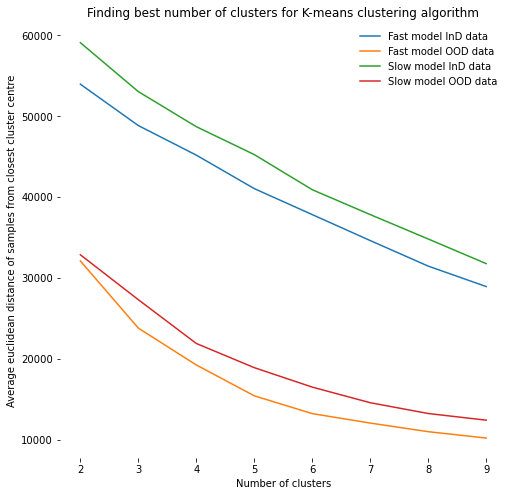

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))

for name, dd in d.items():
    data = {k: v for k, v in dd.items()}
    average_inertia_over_samples = np.array(list(data.values())) / len(data.values())

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.plot(data.keys(), average_inertia_over_samples, label=name)
    ax.set(xlabel= "Number of clusters", ylabel = "Average euclidean distance of samples from closest cluster centre", title='Finding best number of clusters for K-means clustering algorithm')

    print(average_inertia_over_samples.mean())

plt.legend(frameon=False, loc="upper right")
plt.show()


# Clustering with N=3

In [15]:
half = int(len(fast_all_IND_test_activations)/2)
fast_IND_train = fast_all_IND_test_activations[:half, :]
fast_IND_test = fast_all_IND_test_activations[half:half + half, :]
fast_IND_train.shape, fast_IND_test.shape

((5075, 256), (5075, 256))

In [16]:
slow_IND_train = slow_all_IND_test_activations[:half]
slow_IND_test = slow_all_IND_test_activations[half:half + half]
slow_IND_train.shape, slow_IND_test.shape

((5075, 256), (5075, 256))

# Compare train & test & OOD inertias

In [17]:
def inertia(model, labels, data):
    assert len(labels) == len(data)
    return np.square(model.cluster_centers_[labels] - data).sum() / len(data)


def test_my_inertia_function(data):
    model = KMeans(n_clusters=3, random_state=0)

    labels = model.fit_predict(data)
    expected = model.inertia_ / len(data)

    actual = inertia(model, labels, data)

    np.testing.assert_almost_equal(expected, actual)
    return expected, actual


test_my_inertia_function(fast_all_IND_test_activations)

(38.50204175109983, 38.502041751099824)

In [18]:
N = 3

kmeans_model_for_fast = KMeans(n_clusters=N, random_state=0)
fast_train_labels = kmeans_model_for_fast.fit_predict(fast_IND_train)

fast_test_labels = kmeans_model_for_fast.predict(fast_IND_test)
fast_OOD_labels = kmeans_model_for_fast.predict(fast_all_OOD_activations)
fast_IND_inertia = inertia(kmeans_model_for_fast, fast_test_labels, fast_IND_test)
fast_OOD_inertia = inertia(kmeans_model_for_fast, fast_OOD_labels, fast_all_OOD_activations)

kmeans_model_for_fast.inertia_ / len(fast_IND_train), fast_IND_inertia, fast_OOD_inertia

(37.605118471696464, 38.803093314985254, 47.19849347868346)

In [19]:

kmeans_model_for_slow = KMeans(n_clusters=N, random_state=0)
slow_train_labels = kmeans_model_for_slow.fit_predict(slow_IND_train)

slow_test_labels = kmeans_model_for_slow.predict(slow_IND_test)
slow_OOD_labels = kmeans_model_for_slow.predict(slow_all_OOD_activations)
slow_IND_inertia = inertia(kmeans_model_for_slow, slow_test_labels, slow_IND_test)
slow_OOD_inertia = inertia(kmeans_model_for_slow, slow_OOD_labels, slow_all_OOD_activations)

kmeans_model_for_slow.inertia_ / len(slow_IND_train), slow_IND_inertia, slow_OOD_inertia

(42.86019020628164, 42.06488015693454, 83.58616930825146)

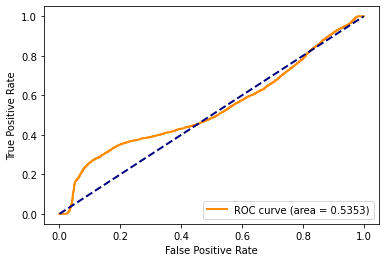

In [20]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc


def prepare_data(model, test_activations, test_labels, ood_activations, ood_labels):
    IND_sample_inertias = samplewise_inertia(model,
                                             test_labels,
                                             test_activations)
    OOD_sample_inertias = samplewise_inertia(model,
                                             ood_labels,
                                             ood_activations)
    IND_sample_inertias = np.vstack([np.zeros(len(IND_sample_inertias)), IND_sample_inertias]).T
    OOD_sample_inertias = np.vstack([np.ones(len(OOD_sample_inertias)), OOD_sample_inertias]).T
    return np.concatenate((IND_sample_inertias, OOD_sample_inertias,))


def samplewise_inertia(model, labels, data):
    return np.sum(np.square(model.cluster_centers_[labels] - data), axis=1)


def draw_auroc_with_cluster_euclidean_distances(model, test_labels, test_activations, ood_labels, ood_activations):
    data = prepare_data(model, test_activations, test_labels, ood_activations, ood_labels)
    lw = 2
    fpr, tpr, _ = roc_curve(data[:, 0], data[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.4f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


draw_auroc_with_cluster_euclidean_distances(
    kmeans_model_for_fast,
    fast_test_labels,
    fast_IND_test,
    fast_OOD_labels,
    fast_all_OOD_activations)


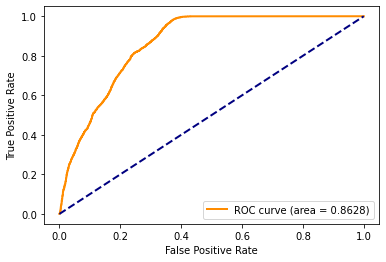

In [21]:
draw_auroc_with_cluster_euclidean_distances(
    kmeans_model_for_slow,
    slow_test_labels,
    slow_IND_test,
    slow_OOD_labels,
    slow_all_OOD_activations)

# How are the samples clustered in these datasets?


# How much do clusters match ground truth angle classes?

In [22]:
fast_gt = np.load(
    '/Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/open-loop-results/nighttime-fast-auto-3d-model-nighttime-fast-auto-data-prediction-and-ground-truth.npy')[
          :, 2]

train_gt = fast_gt[:half]
test_gt = fast_gt[half:half + half]
fast_gt.shape, train_gt.shape, test_gt.shape

((19250,), (5075,), (5075,))

In [23]:
slow_gt = np.load(
    '/Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/open-loop-results/nighttime-slow-auto-3d-model-nighttime-slow-auto-data-prediction-and-ground-truth.npy')[
          :, 2]

train_gt = slow_gt[:half]
test_gt = slow_gt[half:half + half]
slow_gt.shape, train_gt.shape, test_gt.shape

((20304,), (5075,), (5075,))

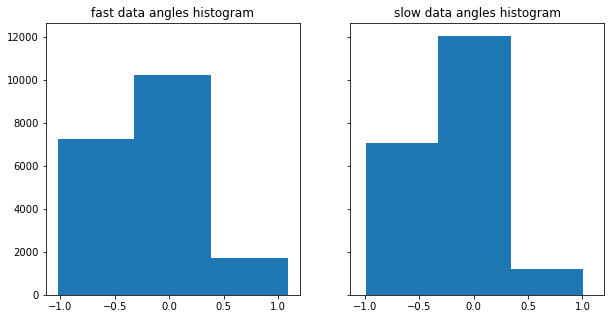

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex='all', sharey='all')

axs.flat[0].hist(fast_gt, bins=3)
axs.flat[0].set_title('fast data angles histogram')
axs.flat[1].hist(slow_gt, bins=3)
axs.flat[1].set_title('slow data angles histogram')
plt.show()

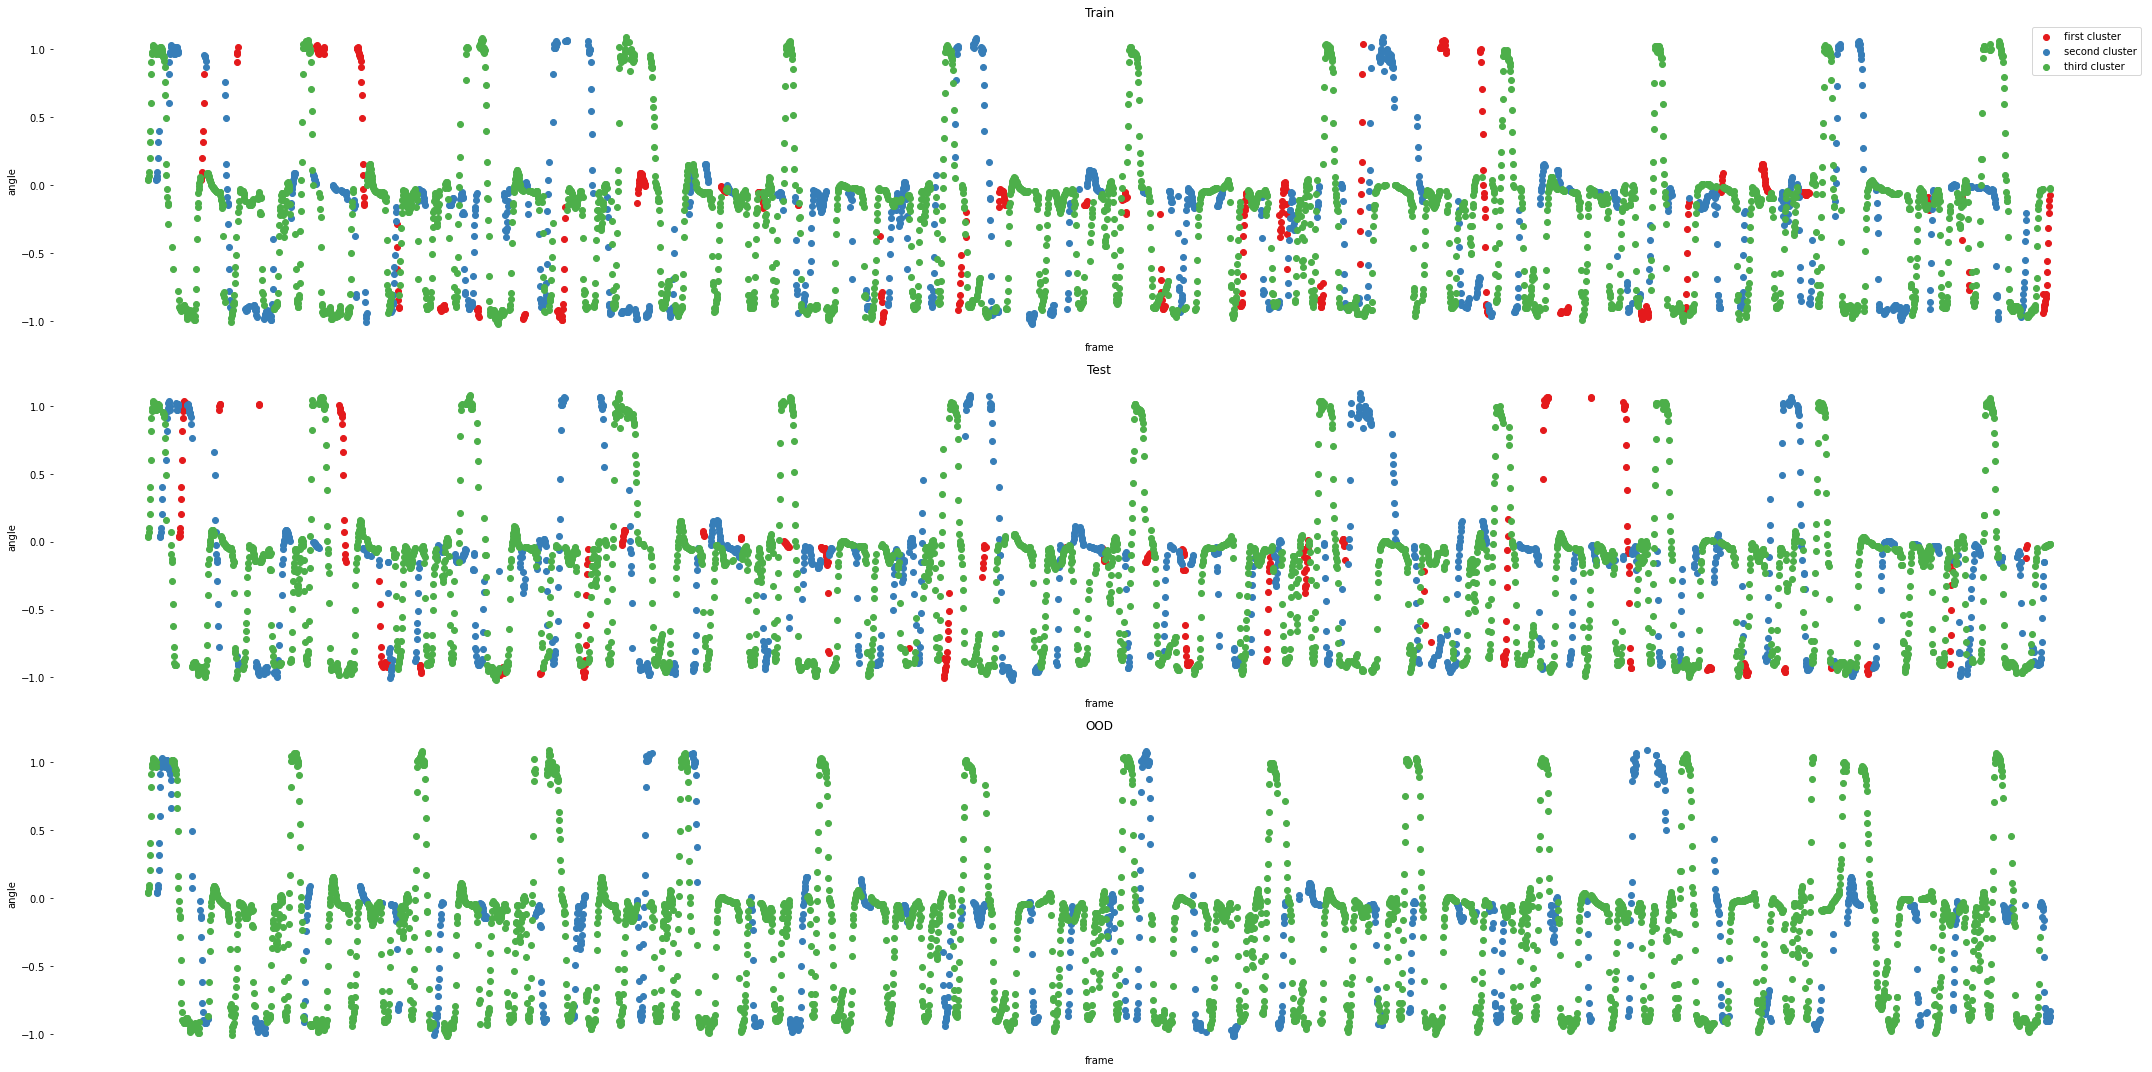

In [25]:
import matplotlib as mpl

fast_OOD_labels = kmeans_model_for_fast.predict(fast_all_OOD_activations[:half])
cmap = mpl.cm.Set1

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(30, 15), sharex='all', sharey='all')

clustermap = {0: 'first', 1: 'second', 2: 'third'}

for ax, labels in zip(axs.flat, [fast_train_labels, fast_test_labels, fast_OOD_labels]):
    for n in range(N):
        labels_ = labels[labels == n]
        ax.scatter(np.array(list(range(len(labels))))[labels == n], fast_gt[:len(labels_)], color=cmap(n),
                   label=f'{clustermap[n]} cluster')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.set(ylabel='angle', xlabel='frame')

axs[0].legend()
axs[0].set_title('Train')
axs[1].set_title('Test')
axs[2].set_title('OOD')
fig.tight_layout()


# assign angles to 3 classes

In [26]:

fast_clazz = np.zeros(len(fast_gt))

fast_clazz[fast_gt < -0.2] = -1
fast_clazz[fast_gt >= -0.2] = 0
fast_clazz[fast_gt > 0.2] = 1

slow_clazz = np.zeros(len(slow_gt))

slow_clazz[slow_gt < -0.2] = -1
slow_clazz[slow_gt >= -0.2] = 0
slow_clazz[slow_gt > 0.2] = 1


In [54]:

def plot_ax(ax, probas, dataset_name):
    bottom = np.zeros(3)
    width = 0.35
    for cluster in ['first', 'second', 'third']:
        cluster_values = []
        angles = ['left', 'centre', 'right']
        for angle in angles:
            try:
                value = probas[angle, cluster]
            except KeyError:
                value = 0
            cluster_values.append(value)
        cluster_values = np.array(cluster_values)
        ax.bar(angles, cluster_values, width, bottom=bottom, label=f'{cluster} cluster')
        bottom += cluster_values
    ax.set_title(f'{dataset_name} dataset')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)


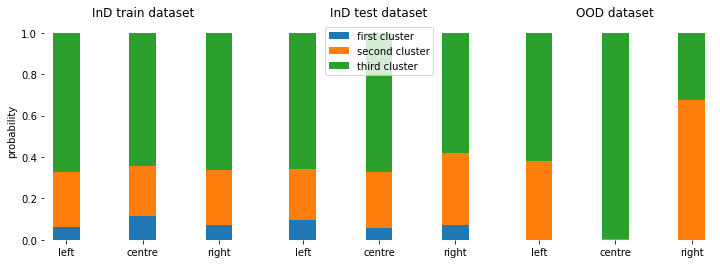

In [56]:
import pandas as pd


def get_probas(clazz, cluster_labels):
    df = pd.DataFrame(np.array([clazz,
                                cluster_labels,
                                np.ones(len(cluster_labels))
                                ]).T,
                      columns=['angle_class', 'cluster', 'counts'])
    df["angle_class"].replace({-1: 'left', 0: 'centre', 1: 'right'}, inplace=True)
    df["cluster"].replace({0: 'first', 1: 'second', 2: 'third'}, inplace=True)
    return df.groupby('angle_class').cluster.apply(lambda g: g.value_counts() / len(g))


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plot_ax(axs[0], get_probas(fast_clazz[:half], fast_train_labels), 'InD train')
plot_ax(axs[1], get_probas(fast_clazz[half:half + half], fast_test_labels), 'InD test')
plot_ax(axs[2], get_probas(slow_clazz[:half], fast_OOD_labels), 'OOD')

axs[1].legend()
axs[0].set_ylabel('probability')
axs[1].get_yaxis().set_ticks([])
axs[2].get_yaxis().set_ticks([])
plt.show()


# TSNE

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=0, learning_rate='auto', init='pca').fit(
    np.concatenate((fast_all_IND_test_activations, fast_all_OOD_activations)))


/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [30]:
labels = np.concatenate((np.zeros(len(fast_all_IND_test_activations)), np.ones(len(fast_all_OOD_activations))))
labels.shape

(20300,)

In [31]:
tsne.embedding_.shape

(20300, 3)

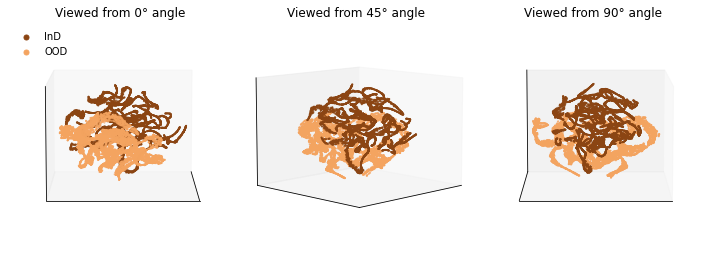

In [37]:
from matplotlib import ticker
import matplotlib


def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, axs = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(10, 5),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    plot__(axs[0], points_color, x, y, z, 0)
    plot__(axs[1], points_color, x, y, z, 45)
    plot__(axs[2], points_color, x, y, z, 90)
    axs[0].legend(frameon=False, loc='upper left', prop={'size': 10}, markerscale=5)
    plt.show()


def plot__(ax, points_color, x, y, z, azim):
    ax.scatter(x[points_color==0], y[points_color==0], z[points_color==0], c='saddlebrown', s=1, label='InD')
    ax.scatter(x[points_color==1], y[points_color==1], z[points_color==1], c='sandybrown', s=1, label='OOD')
    ax.view_init(azim=azim, elev=9)
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.zaxis.set_major_locator(ticker.NullLocator())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)
    ax.set(xticks = [], yticks = [], zticks = [], title=f'Viewed from {azim}° angle')

plot_3d(tsne.embedding_, labels, None)

In [31]:

slow_tsne = TSNE(n_components=3, random_state=0, learning_rate='auto', init='pca').fit(
    np.concatenate((slow_all_IND_test_activations, slow_all_OOD_activations)))

slow_labels = np.concatenate((np.zeros(len(slow_all_IND_test_activations)), np.ones(len(slow_all_OOD_activations))))
plot_3d(slow_tsne.embedding_, slow_labels, 'Slow model tSNE 3D plot')


KeyboardInterrupt: 

In [34]:
train = np.concatenate((tsne.embedding_[:15000], tsne.embedding_[19250:19250 + 15000]))
test = np.concatenate((tsne.embedding_[15000:19250], tsne.embedding_[19250 + 15000:]))

train_labels = np.concatenate((np.zeros(15000), np.ones(15000)))
test_labels = np.concatenate((np.zeros(19250 - 15000), np.ones(9554 - (19250 - 15000))))

fast_all_IND_test_activations.shape, fast_all_OOD_activations.shape, train.shape, test.shape, train_labels.shape, test_labels.shape

((19250, 256), (20304, 256), (30000, 3), (9554, 3), (30000,), (9554,))

In [35]:

from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()

logit.fit(train, train_labels)

logit.score(test, test_labels)

0.8909357337240946

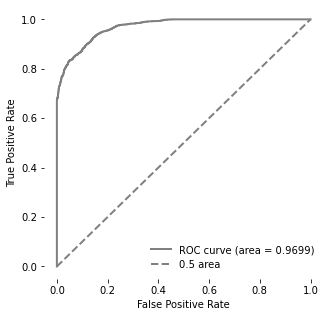

In [100]:
def draw_auroc(labels, scores):
    lw = 2
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(5, 5))

    ax.plot(
        fpr,
        tpr,
        color="grey",
        lw=lw,
        label="ROC curve (area = %0.4f)" % roc_auc,
    )
    ax.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--", label='0.5 area')
    ax.set(xlabel= "False Positive Rate", ylabel = "True Positive Rate")
    ax.legend(frameon=False, loc="lower right")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.show()


draw_auroc(test_labels, logit.predict_proba(test)[:, 1])

In [ ]:

ax.plot(
    fpr,
    tpr,
    color="grey",
    lw=2,
    label="ROC curve (area = %0.4f)" % roc_auc,
)
ax.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--", label='0.5 area')
ax.set(xlabel= "False Positive Rate", ylabel = "True Positive Rate")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(frameon=False, loc="lower right")
plt.show()
